# Example 4: Inverse estimation of soil hydraulic properties using Phydrus and MCMC 
*Authors: M. Vremec & R.A. Collenteur*

---
This notebook is part of a manuscript that is currently being prepared (spring 2020): 

*R.A. Collenteur, et. al. (in preparation) Phydrus: a Python implementation of the Hydrus-1D model.*

---
In this Notebook the model constructed in the previous example is extended for inverse estimation of soil hydrauilic properties 

1. generation of Synthethic Data by Forward Simulation 
2. inverse estimation of soil hydraulic properties using cumulative outflow, profile-averaged water content and matric head data in the objective function
---
In this notebook it is shown how the MCMC-algorithm can be used to estimate the soil hydrauilic properties for a Phydrus model. Apart from Phydrus being installed, the following Python Packages have to be installed:

- [emcee](https://emcee.readthedocs.io/en/stable/user/faq/)
- [lmfit](https://lmfit.github.io/lmfit-py/)
- [corner](https://corner.readthedocs.io)

### 1. Import the Pydrus package

In [1]:
# Import the Python packages used
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import emcee
import phydrus as ps
import corner

ps.set_log_level("ERROR")
%matplotlib inline

run_mcmc = True

### 2. Generation of Synthethic Data by Forward Simulation
In the following code block we recreate the model developed in Example 1.

In [2]:
# Folder where the Hydrus files are to be stored
ws = "output"
exe = os.path.join(os.getcwd(), "../hydrus_mcmc")

# Create model
ml = ps.Model(exe_name=exe, ws_name=ws)

ml.add_time_info(tinit=0, tmax=730, print_times=True)
ml.add_waterflow(model=0, top_bc=3, bot_bc=4)

# Add materials
m = ml.get_empty_material_df(n=2)
m.loc[0:2] = [[0.0, 0.34, 0.01, 1.47, 13, 0.5],
              [0.0, 0.36, 0.02, 1.52, 50, 0.5]]
ml.add_material(m)

bottom = [-30, -100]  # Depth of the soil column
ihead = -500  # Determine initial pressure head

profile = ps.create_profile(bot=bottom, dx=1, h=ihead, mat=[1,2])
ml.add_profile(profile)
ml.add_obs_nodes([-30, -60])

atm = pd.read_csv("../data/atmosphere.csv", index_col=0)
ml.add_atmospheric_bc(atm, hcrits=0)

Time to write the input files:

In [3]:
%%timeit
ml.write_input()

82.4 ms ± 598 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Time to execute Hydrus-1D:

In [4]:
%%timeit
ml.simulate()

122 ms ± 500 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 3. Plot the seepage, averaged water content and matric potential over time

In [5]:
df = ml.read_obs_node()
vwc_1=df[ml.obs_nodes[0]].loc[:,'theta']
vwc_2=df[ml.obs_nodes[1]].loc[:,'theta']

# Add gaussian noise
np.random.seed(0)
std = 0.005
g_noise = np.random.normal(0, std, len(vwc_1))
synth_vwc_1 = vwc_1 + g_noise
synth_vwc_2 = vwc_2 + g_noise

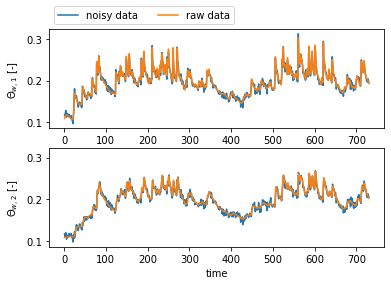

In [6]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(6, 4), sharey=True)

synth_vwc_1.plot(ax=ax1, label="noisy data")
vwc_1.plot(ax=ax1, label="raw data")
ax1.legend(ncol=2, bbox_to_anchor=[0,1], loc=3)
ax1.set_ylabel("$\Theta_{w,1}$ [-]")

synth_vwc_2.plot(ax=ax2)
vwc_2.plot(ax=ax2)
ax2.set_ylabel("$\Theta_{w,2}$ [-]");

### 5. Use EMCEE for inverse estimation: Function Definition

In [7]:
# Prior
def lnprior_uniform(params,bounds):
    if np.any(params < bounds[:,0]) or np.any(params > bounds[:,1]):
        return -np.inf
    else:
        return 0

# Gaussian Log-Likelihood
def lnlike(params, synth_1, synth_2):
    thS1, a1, n1, Ks1, l1, thS2, a2, n2, Ks2, l2, sigma_1, sigma_2 = params
    
    ml.materials.iloc[:, 1:] =[[thS1, a1, n1, Ks1, l1],
                               [thS2, a2, n2, Ks2, l2]]
    ml.write_selector() 
    ml.simulate()
    
    # Read simulated WVC frorm file
    modeled = ml.read_obs_node()
    mod_1 = modeled[ml.obs_nodes[0]].loc[:,'theta']
    mod_2 = modeled[ml.obs_nodes[1]].loc[:,'theta']
    
    if len(mod_1) < len(synth_1):
        print ("Hydrus-1D model did not converge")
        SSQ_1 = 1e+7
        SSQ_2 = 1e+7
    else:
        SSQ_1 = np.sum(((mod_1 - synth_1)**2).sum())
        SSQ_2 = np.sum(((mod_2 - synth_2)**2).sum())    
        
    N_1 = synth_1.size
    N_2 = synth_2.size
    
    lnlike_1 = -0.5 * N_1 * np.log(2 * np.pi) - 0.5 * N_1 * np.log(sigma_1**2) / -(0.5 / sigma_1**2) * SSQ_1
    lnlike_2 = -0.5 * N_2 * np.log(2 * np.pi) - 0.5 * N_2 * np.log(sigma_2**2) / -(0.5 / sigma_2**2) * SSQ_2

    return lnlike_1+lnlike_2
    return lnlike_1 + lnlike_2

# Full Log-Probability
def lnprob(params, synth_1, synth_2, bounds):
    lp = lnprior_uniform(params, bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, synth_1, synth_2)

## Run MCMC Analysis

In [8]:
# UNCERTAINTY ANALYSIS
lb = np.array([0.25, 0.001, 1.1, 1, -1, 0.25, 0.001, 1.1, 1, -1, 0, 0])
ub = np.array([0.45, 0.1, 2, 100, 3, 0.45, 0.1, 2, 100, 3, 0.05, 0.05])
bounds = np.vstack((np.array(lb).T, np.array(ub).T)).T

ndim = len(bounds)
nwalkers = 50
filename = "MCMC_test.h5"

backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, backend=backend,
                                args=[synth_vwc_1, synth_vwc_2, bounds], a=1.)
p0 = emcee.utils.sample_ball(
    [0.34, 0.03, 1.7, 15, 0.1, 0.34, 0.03, 1.7, 40, 0.1, 0.007, 0.007],
    [0.001] * ndim, size=nwalkers)

truth = np.append(m.iloc[:, 1:].to_numpy().reshape(1,10), [std, std])

# Only run if run_mcmc equals True
if run_mcmc is True:
    sampler.run_mcmc(p0, 2000, progress=True)
    print(lnlike(truth, synth_vwc_1, synth_vwc_2))

  7%|▋         | 135/2000 [10:26<2:09:57,  4.18s/it]

Hydrus-1D model did not converge


  7%|▋         | 141/2000 [10:50<2:07:05,  4.10s/it]

Hydrus-1D model did not converge


  7%|▋         | 146/2000 [11:13<2:20:38,  4.55s/it]

Hydrus-1D model did not converge


  8%|▊         | 158/2000 [12:02<2:16:53,  4.46s/it]

Hydrus-1D model did not converge


  9%|▉         | 178/2000 [13:27<2:05:02,  4.12s/it]

Hydrus-1D model did not converge


 12%|█▏        | 245/2000 [18:06<2:11:49,  4.51s/it]

Hydrus-1D model did not converge


 14%|█▍        | 276/2000 [20:23<2:21:35,  4.93s/it]

Hydrus-1D model did not converge


 14%|█▍        | 287/2000 [21:18<2:12:33,  4.64s/it]

Hydrus-1D model did not converge


 17%|█▋        | 337/2000 [25:22<2:22:10,  5.13s/it]

Hydrus-1D model did not converge


 19%|█▉        | 376/2000 [28:43<1:59:17,  4.41s/it]

Hydrus-1D model did not converge


 20%|██        | 407/2000 [31:04<2:02:05,  4.60s/it]

Hydrus-1D model did not converge


 21%|██        | 411/2000 [31:20<1:55:07,  4.35s/it]

Hydrus-1D model did not converge


 21%|██▏       | 428/2000 [32:53<3:16:42,  7.51s/it]

Hydrus-1D model did not converge


 22%|██▏       | 438/2000 [33:39<1:59:57,  4.61s/it]

Hydrus-1D model did not converge


 22%|██▏       | 446/2000 [34:30<2:11:40,  5.08s/it]

Hydrus-1D model did not converge


 24%|██▎       | 474/2000 [37:13<2:47:31,  6.59s/it]

Hydrus-1D model did not converge


 25%|██▍       | 493/2000 [38:58<1:57:03,  4.66s/it]

Hydrus-1D model did not converge


 25%|██▌       | 503/2000 [39:55<2:19:47,  5.60s/it]

Hydrus-1D model did not converge


 26%|██▌       | 523/2000 [41:44<2:12:29,  5.38s/it]

Hydrus-1D model did not converge


 27%|██▋       | 532/2000 [42:32<2:04:36,  5.09s/it]

Hydrus-1D model did not converge


 27%|██▋       | 538/2000 [43:07<2:07:37,  5.24s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 28%|██▊       | 559/2000 [45:12<2:28:15,  6.17s/it]

Hydrus-1D model did not converge


 28%|██▊       | 567/2000 [45:52<2:06:26,  5.29s/it]

Hydrus-1D model did not converge


 29%|██▊       | 572/2000 [46:17<2:02:50,  5.16s/it]

Hydrus-1D model did not converge


 29%|██▉       | 584/2000 [48:59<4:39:07, 11.83s/it] 

Hydrus-1D model did not converge


 30%|██▉       | 595/2000 [50:05<2:04:14,  5.31s/it]

Hydrus-1D model did not converge


 30%|██▉       | 599/2000 [50:30<2:35:26,  6.66s/it]

Hydrus-1D model did not converge


 30%|███       | 601/2000 [50:39<2:10:30,  5.60s/it]

Hydrus-1D model did not converge


 30%|███       | 602/2000 [50:43<1:58:35,  5.09s/it]

Hydrus-1D model did not converge


 32%|███▏      | 633/2000 [54:12<3:00:24,  7.92s/it]

Hydrus-1D model did not converge


 33%|███▎      | 669/2000 [57:55<1:48:56,  4.91s/it]

Hydrus-1D model did not converge


 35%|███▍      | 699/2000 [1:01:27<2:19:46,  6.45s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 36%|███▌      | 722/2000 [1:03:44<2:58:49,  8.40s/it]

Hydrus-1D model did not converge


 36%|███▋      | 728/2000 [1:04:29<2:39:56,  7.54s/it]

Hydrus-1D model did not converge


 36%|███▋      | 730/2000 [1:04:40<2:18:32,  6.55s/it]

Hydrus-1D model did not converge


 37%|███▋      | 731/2000 [1:04:46<2:15:34,  6.41s/it]

Hydrus-1D model did not converge


 37%|███▋      | 737/2000 [1:05:51<3:40:57, 10.50s/it]

Hydrus-1D model did not converge


 37%|███▋      | 738/2000 [1:06:05<3:59:15, 11.37s/it]

Hydrus-1D model did not converge


 37%|███▋      | 741/2000 [1:06:41<4:14:58, 12.15s/it]

Hydrus-1D model did not converge


 38%|███▊      | 758/2000 [1:09:11<2:04:37,  6.02s/it]

Hydrus-1D model did not converge


 38%|███▊      | 764/2000 [1:10:01<2:36:43,  7.61s/it]

Hydrus-1D model did not converge


 38%|███▊      | 768/2000 [1:10:28<2:36:14,  7.61s/it]

Hydrus-1D model did not converge


 39%|███▊      | 771/2000 [1:10:51<2:29:08,  7.28s/it]

Hydrus-1D model did not converge


 39%|███▊      | 772/2000 [1:11:04<3:02:01,  8.89s/it]

Hydrus-1D model did not converge


 39%|███▊      | 773/2000 [1:11:11<2:49:43,  8.30s/it]

Hydrus-1D model did not converge


 39%|███▉      | 775/2000 [1:11:23<2:25:20,  7.12s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 39%|███▉      | 776/2000 [1:11:29<2:19:09,  6.82s/it]

Hydrus-1D model did not converge


 39%|███▉      | 784/2000 [1:12:36<2:58:14,  8.80s/it]

Hydrus-1D model did not converge


 39%|███▉      | 785/2000 [1:12:40<2:25:48,  7.20s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 40%|███▉      | 790/2000 [1:13:11<1:58:36,  5.88s/it]

Hydrus-1D model did not converge


 40%|███▉      | 791/2000 [1:13:19<2:12:22,  6.57s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 40%|███▉      | 792/2000 [1:13:25<2:08:56,  6.40s/it]

Hydrus-1D model did not converge


 40%|███▉      | 795/2000 [1:13:42<1:58:33,  5.90s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 40%|████      | 800/2000 [1:14:10<2:05:03,  6.25s/it]

Hydrus-1D model did not converge


 40%|████      | 801/2000 [1:14:17<2:07:37,  6.39s/it]

Hydrus-1D model did not converge


 40%|████      | 804/2000 [1:14:31<1:41:35,  5.10s/it]

Hydrus-1D model did not converge


 40%|████      | 808/2000 [1:14:52<1:39:34,  5.01s/it]

Hydrus-1D model did not converge


 41%|████      | 813/2000 [1:15:29<2:23:33,  7.26s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 41%|████      | 817/2000 [1:16:06<3:06:02,  9.44s/it]

Hydrus-1D model did not converge


 42%|████▏     | 830/2000 [1:17:32<1:54:26,  5.87s/it]

Hydrus-1D model did not converge


 42%|████▏     | 841/2000 [1:18:40<1:44:45,  5.42s/it]

Hydrus-1D model did not converge


 42%|████▏     | 843/2000 [1:18:56<1:59:34,  6.20s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 42%|████▏     | 848/2000 [1:19:23<1:51:42,  5.82s/it]

Hydrus-1D model did not converge


 43%|████▎     | 851/2000 [1:19:48<2:08:30,  6.71s/it]

Hydrus-1D model did not converge


 43%|████▎     | 857/2000 [1:20:36<2:12:39,  6.96s/it]

Hydrus-1D model did not converge


 44%|████▎     | 873/2000 [1:23:11<4:02:43, 12.92s/it]

Hydrus-1D model did not converge


 44%|████▍     | 881/2000 [1:24:03<2:13:34,  7.16s/it]

Hydrus-1D model did not converge


 44%|████▍     | 886/2000 [1:24:30<1:47:35,  5.79s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 45%|████▍     | 892/2000 [1:25:12<2:14:15,  7.27s/it]

Hydrus-1D model did not converge


 45%|████▍     | 893/2000 [1:25:20<2:19:04,  7.54s/it]

Hydrus-1D model did not converge


 45%|████▍     | 894/2000 [1:25:23<1:54:56,  6.24s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 45%|████▍     | 895/2000 [1:25:38<2:43:16,  8.87s/it]

Hydrus-1D model did not converge


 45%|████▍     | 896/2000 [1:25:43<2:19:44,  7.59s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 45%|████▍     | 898/2000 [1:26:00<2:25:28,  7.92s/it]

Hydrus-1D model did not converge


 45%|████▍     | 899/2000 [1:26:17<3:16:10, 10.69s/it]

Hydrus-1D model did not converge


 45%|████▌     | 901/2000 [1:26:32<2:43:17,  8.91s/it]

Hydrus-1D model did not converge


 45%|████▌     | 906/2000 [1:26:58<1:44:48,  5.75s/it]

Hydrus-1D model did not converge


 46%|████▌     | 917/2000 [1:28:08<1:34:58,  5.26s/it]

Hydrus-1D model did not converge


 46%|████▌     | 919/2000 [1:28:21<1:43:34,  5.75s/it]

Hydrus-1D model did not converge


 46%|████▌     | 922/2000 [1:28:38<1:38:05,  5.46s/it]

Hydrus-1D model did not converge


 47%|████▋     | 935/2000 [1:29:53<1:34:36,  5.33s/it]

Hydrus-1D model did not converge


 47%|████▋     | 938/2000 [1:30:11<1:46:34,  6.02s/it]

Hydrus-1D model did not converge


 47%|████▋     | 941/2000 [1:30:26<1:38:38,  5.59s/it]

Hydrus-1D model did not converge


 47%|████▋     | 944/2000 [1:30:43<1:39:01,  5.63s/it]

Hydrus-1D model did not converge


 47%|████▋     | 946/2000 [1:30:58<1:57:46,  6.70s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 48%|████▊     | 955/2000 [1:31:50<1:36:23,  5.53s/it]

Hydrus-1D model did not converge


 48%|████▊     | 956/2000 [1:31:55<1:33:33,  5.38s/it]

Hydrus-1D model did not converge


 48%|████▊     | 959/2000 [1:32:19<2:02:24,  7.05s/it]

Hydrus-1D model did not converge


 48%|████▊     | 969/2000 [1:33:18<1:32:08,  5.36s/it]

Hydrus-1D model did not converge


 49%|████▊     | 974/2000 [1:33:42<1:23:40,  4.89s/it]

Hydrus-1D model did not converge


 49%|████▉     | 984/2000 [1:34:28<1:13:44,  4.36s/it]

Hydrus-1D model did not converge


 49%|████▉     | 987/2000 [1:34:42<1:16:11,  4.51s/it]

Hydrus-1D model did not converge


 49%|████▉     | 989/2000 [1:34:50<1:10:22,  4.18s/it]

Hydrus-1D model did not converge


 50%|████▉     | 997/2000 [1:35:29<1:23:46,  5.01s/it]

Hydrus-1D model did not converge


 50%|█████     | 1008/2000 [1:36:25<1:20:26,  4.87s/it]

Hydrus-1D model did not converge


 51%|█████     | 1014/2000 [1:37:00<1:38:55,  6.02s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 51%|█████     | 1023/2000 [1:38:07<1:57:30,  7.22s/it]

Hydrus-1D model did not converge


 51%|█████     | 1024/2000 [1:38:13<1:48:57,  6.70s/it]

Hydrus-1D model did not converge


 53%|█████▎    | 1059/2000 [1:42:23<1:47:56,  6.88s/it]

Hydrus-1D model did not converge


 53%|█████▎    | 1069/2000 [1:43:34<1:49:17,  7.04s/it]

Hydrus-1D model did not converge


 54%|█████▎    | 1073/2000 [1:44:03<1:51:46,  7.23s/it]

Hydrus-1D model did not converge


 54%|█████▎    | 1074/2000 [1:44:08<1:40:07,  6.49s/it]

Hydrus-1D model did not converge


 54%|█████▍    | 1080/2000 [1:44:52<1:50:25,  7.20s/it]

Hydrus-1D model did not converge


 54%|█████▍    | 1085/2000 [1:45:30<2:02:17,  8.02s/it]

Hydrus-1D model did not converge


 56%|█████▋    | 1128/2000 [1:50:53<2:15:00,  9.29s/it]

Hydrus-1D model did not converge


 57%|█████▋    | 1145/2000 [1:52:46<1:33:18,  6.55s/it]

Hydrus-1D model did not converge


 57%|█████▋    | 1148/2000 [1:53:09<1:36:34,  6.80s/it]

Hydrus-1D model did not converge


 57%|█████▊    | 1150/2000 [1:53:22<1:33:28,  6.60s/it]

Hydrus-1D model did not converge


 58%|█████▊    | 1153/2000 [1:53:46<1:44:55,  7.43s/it]

Hydrus-1D model did not converge


 58%|█████▊    | 1164/2000 [1:55:03<1:45:30,  7.57s/it]

Hydrus-1D model did not converge


 58%|█████▊    | 1169/2000 [1:55:41<1:34:29,  6.82s/it]

Hydrus-1D model did not converge


 59%|█████▉    | 1177/2000 [1:56:31<1:22:05,  5.98s/it]

Hydrus-1D model did not converge


 59%|█████▉    | 1179/2000 [1:56:46<1:31:12,  6.67s/it]

Hydrus-1D model did not converge


 59%|█████▉    | 1188/2000 [1:58:15<1:49:01,  8.06s/it]

Hydrus-1D model did not converge


 60%|█████▉    | 1193/2000 [1:58:50<1:43:42,  7.71s/it]

Hydrus-1D model did not converge


 60%|█████▉    | 1197/2000 [1:59:20<1:28:12,  6.59s/it]

Hydrus-1D model did not converge


 60%|██████    | 1201/2000 [1:59:46<1:33:26,  7.02s/it]

Hydrus-1D model did not converge


 60%|██████    | 1202/2000 [1:59:55<1:43:40,  7.80s/it]

Hydrus-1D model did not converge


 60%|██████    | 1209/2000 [2:00:46<1:20:10,  6.08s/it]

Hydrus-1D model did not converge


 61%|██████    | 1211/2000 [2:01:06<1:42:14,  7.78s/it]

Hydrus-1D model did not converge


 61%|██████    | 1212/2000 [2:01:23<2:18:30, 10.55s/it]

Hydrus-1D model did not converge


 61%|██████    | 1224/2000 [2:02:40<1:15:18,  5.82s/it]

Hydrus-1D model did not converge


 61%|██████▏   | 1228/2000 [2:03:12<1:35:20,  7.41s/it]

Hydrus-1D model did not converge


 61%|██████▏   | 1229/2000 [2:03:17<1:27:09,  6.78s/it]

Hydrus-1D model did not converge


 62%|██████▏   | 1235/2000 [2:03:56<1:20:39,  6.33s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 62%|██████▏   | 1241/2000 [2:05:10<2:05:19,  9.91s/it]

Hydrus-1D model did not converge


 62%|██████▏   | 1245/2000 [2:05:44<1:43:33,  8.23s/it]

Hydrus-1D model did not converge


 62%|██████▏   | 1246/2000 [2:05:50<1:36:41,  7.69s/it]

Hydrus-1D model did not converge


 62%|██████▎   | 1250/2000 [2:06:21<1:32:35,  7.41s/it]

Hydrus-1D model did not converge


 63%|██████▎   | 1259/2000 [2:07:33<1:20:17,  6.50s/it]

Hydrus-1D model did not converge


 63%|██████▎   | 1268/2000 [2:08:56<1:24:06,  6.89s/it]

Hydrus-1D model did not converge


 64%|██████▎   | 1273/2000 [2:09:35<1:38:48,  8.16s/it]

Hydrus-1D model did not converge


 64%|██████▎   | 1274/2000 [2:09:40<1:28:55,  7.35s/it]

Hydrus-1D model did not converge


 64%|██████▍   | 1277/2000 [2:10:01<1:24:18,  7.00s/it]

Hydrus-1D model did not converge


 64%|██████▍   | 1279/2000 [2:10:16<1:32:09,  7.67s/it]

Hydrus-1D model did not converge


 64%|██████▍   | 1282/2000 [2:10:35<1:25:31,  7.15s/it]

Hydrus-1D model did not converge


 64%|██████▍   | 1289/2000 [2:11:15<1:05:39,  5.54s/it]

Hydrus-1D model did not converge


 64%|██████▍   | 1290/2000 [2:11:25<1:19:37,  6.73s/it]

Hydrus-1D model did not converge


 65%|██████▍   | 1294/2000 [2:12:06<1:42:04,  8.68s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 65%|██████▌   | 1301/2000 [2:13:08<1:47:03,  9.19s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 65%|██████▌   | 1304/2000 [2:13:36<1:48:40,  9.37s/it]

Hydrus-1D model did not converge


 65%|██████▌   | 1305/2000 [2:13:40<1:31:38,  7.91s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 65%|██████▌   | 1309/2000 [2:14:40<2:07:07, 11.04s/it]

Hydrus-1D model did not converge


 66%|██████▌   | 1310/2000 [2:14:45<1:45:59,  9.22s/it]

Hydrus-1D model did not converge


 66%|██████▌   | 1312/2000 [2:15:01<1:42:21,  8.93s/it]

Hydrus-1D model did not converge


 66%|██████▌   | 1313/2000 [2:15:05<1:26:02,  7.51s/it]

Hydrus-1D model did not converge


 66%|██████▌   | 1314/2000 [2:15:16<1:35:44,  8.37s/it]

Hydrus-1D model did not converge


 66%|██████▌   | 1315/2000 [2:15:20<1:21:37,  7.15s/it]

Hydrus-1D model did not converge


 66%|██████▌   | 1318/2000 [2:16:09<2:16:43, 12.03s/it]

Hydrus-1D model did not converge


 66%|██████▌   | 1319/2000 [2:16:14<1:53:52, 10.03s/it]

Hydrus-1D model did not converge


 66%|██████▌   | 1320/2000 [2:16:26<2:01:41, 10.74s/it]

Hydrus-1D model did not converge


 66%|██████▌   | 1323/2000 [2:16:46<1:24:12,  7.46s/it]

Hydrus-1D model did not converge


 66%|██████▋   | 1325/2000 [2:17:09<1:44:50,  9.32s/it]

Hydrus-1D model did not converge


 66%|██████▋   | 1327/2000 [2:17:31<1:49:39,  9.78s/it]

Hydrus-1D model did not converge


 66%|██████▋   | 1328/2000 [2:17:36<1:31:33,  8.18s/it]

Hydrus-1D model did not converge


 67%|██████▋   | 1333/2000 [2:18:07<1:12:26,  6.52s/it]

Hydrus-1D model did not converge


 67%|██████▋   | 1335/2000 [2:18:21<1:15:47,  6.84s/it]

Hydrus-1D model did not converge


 67%|██████▋   | 1336/2000 [2:18:31<1:27:38,  7.92s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 67%|██████▋   | 1338/2000 [2:19:03<2:09:44, 11.76s/it]

Hydrus-1D model did not converge


 67%|██████▋   | 1340/2000 [2:19:18<1:42:04,  9.28s/it]

Hydrus-1D model did not converge


 67%|██████▋   | 1344/2000 [2:19:39<1:14:27,  6.81s/it]

Hydrus-1D model did not converge


 67%|██████▋   | 1346/2000 [2:19:52<1:10:26,  6.46s/it]

Hydrus-1D model did not converge


 68%|██████▊   | 1352/2000 [2:20:49<1:12:36,  6.72s/it]

Hydrus-1D model did not converge


 68%|██████▊   | 1355/2000 [2:21:13<1:24:19,  7.84s/it]

Hydrus-1D model did not converge


 68%|██████▊   | 1358/2000 [2:21:48<1:49:32, 10.24s/it]

Hydrus-1D model did not converge


 68%|██████▊   | 1365/2000 [2:22:35<1:13:41,  6.96s/it]

Hydrus-1D model did not converge


 68%|██████▊   | 1368/2000 [2:22:58<1:18:52,  7.49s/it]

Hydrus-1D model did not converge


 69%|██████▊   | 1373/2000 [2:23:56<1:51:48, 10.70s/it]

Hydrus-1D model did not converge


 69%|██████▉   | 1385/2000 [2:25:18<1:08:39,  6.70s/it]

Hydrus-1D model did not converge


 70%|██████▉   | 1395/2000 [2:26:33<1:03:16,  6.28s/it]

Hydrus-1D model did not converge


 70%|███████   | 1406/2000 [2:27:40<1:09:59,  7.07s/it]

Hydrus-1D model did not converge


 71%|███████▏  | 1426/2000 [2:30:08<1:08:11,  7.13s/it]

Hydrus-1D model did not converge


 71%|███████▏  | 1429/2000 [2:30:24<55:11,  5.80s/it]  

Hydrus-1D model did not converge


 72%|███████▏  | 1435/2000 [2:31:02<1:01:40,  6.55s/it]

Hydrus-1D model did not converge


 72%|███████▏  | 1438/2000 [2:31:22<1:02:06,  6.63s/it]

Hydrus-1D model did not converge


 72%|███████▏  | 1444/2000 [2:31:59<54:03,  5.83s/it]  

Hydrus-1D model did not converge


 72%|███████▏  | 1449/2000 [2:32:29<52:11,  5.68s/it]  

Hydrus-1D model did not converge


 73%|███████▎  | 1458/2000 [2:33:35<1:04:47,  7.17s/it]

Hydrus-1D model did not converge


 73%|███████▎  | 1465/2000 [2:34:35<1:10:50,  7.95s/it]

Hydrus-1D model did not converge


 73%|███████▎  | 1469/2000 [2:35:09<1:09:04,  7.81s/it]

Hydrus-1D model did not converge


 74%|███████▍  | 1477/2000 [2:36:11<1:05:44,  7.54s/it]

Hydrus-1D model did not converge


 74%|███████▍  | 1478/2000 [2:36:17<1:01:16,  7.04s/it]

Hydrus-1D model did not converge


 74%|███████▍  | 1480/2000 [2:36:25<47:52,  5.52s/it]  

Hydrus-1D model did not converge


 74%|███████▍  | 1481/2000 [2:36:35<58:38,  6.78s/it]

Hydrus-1D model did not converge


 75%|███████▍  | 1496/2000 [2:38:08<55:17,  6.58s/it]  

Hydrus-1D model did not converge


 75%|███████▌  | 1502/2000 [2:38:44<51:38,  6.22s/it]

Hydrus-1D model did not converge


 76%|███████▌  | 1511/2000 [2:39:38<51:01,  6.26s/it]

Hydrus-1D model did not converge


 76%|███████▌  | 1521/2000 [2:40:33<42:31,  5.33s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 76%|███████▋  | 1527/2000 [2:41:07<40:31,  5.14s/it]

Hydrus-1D model did not converge


 77%|███████▋  | 1536/2000 [2:42:08<48:20,  6.25s/it]

Hydrus-1D model did not converge


 78%|███████▊  | 1551/2000 [2:43:47<46:51,  6.26s/it]  

Hydrus-1D model did not converge


 78%|███████▊  | 1557/2000 [2:44:23<45:46,  6.20s/it]

Hydrus-1D model did not converge


 78%|███████▊  | 1561/2000 [2:44:51<49:18,  6.74s/it]

Hydrus-1D model did not converge


 78%|███████▊  | 1570/2000 [2:45:44<40:35,  5.66s/it]

Hydrus-1D model did not converge


 79%|███████▉  | 1579/2000 [2:46:34<36:18,  5.18s/it]

Hydrus-1D model did not converge


 79%|███████▉  | 1583/2000 [2:46:57<38:40,  5.56s/it]

Hydrus-1D model did not converge


 79%|███████▉  | 1587/2000 [2:47:21<41:13,  5.99s/it]

Hydrus-1D model did not converge


 80%|███████▉  | 1590/2000 [2:47:40<40:52,  5.98s/it]

Hydrus-1D model did not converge


 80%|███████▉  | 1594/2000 [2:48:03<37:45,  5.58s/it]

Hydrus-1D model did not converge


 80%|███████▉  | 1597/2000 [2:48:19<38:00,  5.66s/it]

Hydrus-1D model did not converge


 80%|███████▉  | 1598/2000 [2:48:37<1:03:15,  9.44s/it]

Hydrus-1D model did not converge


 80%|████████  | 1601/2000 [2:48:58<48:29,  7.29s/it]  

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 81%|████████  | 1614/2000 [2:50:17<35:41,  5.55s/it]

Hydrus-1D model did not converge


 81%|████████  | 1621/2000 [2:51:01<39:00,  6.18s/it]

Hydrus-1D model did not converge


 81%|████████  | 1622/2000 [2:51:06<37:06,  5.89s/it]

Hydrus-1D model did not converge


 81%|████████▏ | 1625/2000 [2:51:19<30:28,  4.88s/it]

Hydrus-1D model did not converge


 82%|████████▏ | 1641/2000 [2:52:58<43:11,  7.22s/it]

Hydrus-1D model did not converge


 82%|████████▏ | 1649/2000 [2:53:40<29:33,  5.05s/it]

Hydrus-1D model did not converge


 83%|████████▎ | 1652/2000 [2:53:56<29:14,  5.04s/it]

Hydrus-1D model did not converge


 83%|████████▎ | 1655/2000 [2:54:17<32:52,  5.72s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 83%|████████▎ | 1656/2000 [2:54:22<32:39,  5.69s/it]

Hydrus-1D model did not converge


 83%|████████▎ | 1660/2000 [2:54:46<33:36,  5.93s/it]

Hydrus-1D model did not converge


 83%|████████▎ | 1667/2000 [2:55:29<33:32,  6.04s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 83%|████████▎ | 1669/2000 [2:55:49<43:28,  7.88s/it]

Hydrus-1D model did not converge


 84%|████████▍ | 1681/2000 [2:57:08<38:11,  7.18s/it]

Hydrus-1D model did not converge


 84%|████████▍ | 1682/2000 [2:57:19<44:51,  8.47s/it]

Hydrus-1D model did not converge


 84%|████████▍ | 1685/2000 [2:57:35<33:41,  6.42s/it]

Hydrus-1D model did not converge


 84%|████████▍ | 1690/2000 [2:58:24<55:03, 10.66s/it]

Hydrus-1D model did not converge


 85%|████████▍ | 1696/2000 [2:59:02<34:22,  6.78s/it]

Hydrus-1D model did not converge


 85%|████████▍ | 1699/2000 [2:59:17<27:12,  5.42s/it]

Hydrus-1D model did not converge


 85%|████████▌ | 1702/2000 [2:59:36<28:43,  5.78s/it]

Hydrus-1D model did not converge


 85%|████████▌ | 1706/2000 [3:00:09<39:25,  8.05s/it]

Hydrus-1D model did not converge


 85%|████████▌ | 1707/2000 [3:00:14<34:59,  7.17s/it]

Hydrus-1D model did not converge


 85%|████████▌ | 1709/2000 [3:00:26<32:18,  6.66s/it]

Hydrus-1D model did not converge


 86%|████████▌ | 1712/2000 [3:00:45<30:39,  6.39s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 86%|████████▌ | 1713/2000 [3:00:52<31:29,  6.58s/it]

Hydrus-1D model did not converge


 86%|████████▌ | 1723/2000 [3:02:15<28:51,  6.25s/it]

Hydrus-1D model did not converge


 86%|████████▋ | 1727/2000 [3:02:41<29:52,  6.57s/it]

Hydrus-1D model did not converge


 86%|████████▋ | 1730/2000 [3:03:02<29:56,  6.65s/it]

Hydrus-1D model did not converge


 87%|████████▋ | 1738/2000 [3:03:57<30:07,  6.90s/it]

Hydrus-1D model did not converge


 87%|████████▋ | 1740/2000 [3:04:11<29:14,  6.75s/it]

Hydrus-1D model did not converge


 87%|████████▋ | 1744/2000 [3:04:47<32:56,  7.72s/it]

Hydrus-1D model did not converge


 87%|████████▋ | 1745/2000 [3:04:55<32:29,  7.64s/it]

Hydrus-1D model did not converge


 87%|████████▋ | 1747/2000 [3:05:12<33:57,  8.05s/it]

Hydrus-1D model did not converge


 87%|████████▋ | 1748/2000 [3:05:18<32:19,  7.69s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge
Hydrus-1D model did not converge


 88%|████████▊ | 1751/2000 [3:05:46<34:15,  8.25s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 88%|████████▊ | 1753/2000 [3:06:02<32:48,  7.97s/it]

Hydrus-1D model did not converge


 88%|████████▊ | 1756/2000 [3:06:27<33:21,  8.20s/it]

Hydrus-1D model did not converge


 88%|████████▊ | 1758/2000 [3:06:44<33:07,  8.21s/it]

Hydrus-1D model did not converge


 88%|████████▊ | 1759/2000 [3:06:54<35:46,  8.91s/it]

Hydrus-1D model did not converge


 88%|████████▊ | 1763/2000 [3:07:24<29:27,  7.46s/it]

Hydrus-1D model did not converge


 88%|████████▊ | 1766/2000 [3:07:50<32:10,  8.25s/it]

Hydrus-1D model did not converge


 88%|████████▊ | 1769/2000 [3:08:05<23:50,  6.19s/it]

Hydrus-1D model did not converge


 89%|████████▊ | 1773/2000 [3:08:34<27:07,  7.17s/it]

Hydrus-1D model did not converge


 89%|████████▊ | 1774/2000 [3:08:41<26:54,  7.14s/it]

Hydrus-1D model did not converge


 89%|████████▉ | 1775/2000 [3:08:46<24:12,  6.46s/it]

Hydrus-1D model did not converge


 89%|████████▉ | 1776/2000 [3:08:52<24:17,  6.51s/it]

Hydrus-1D model did not converge


 89%|████████▉ | 1782/2000 [3:09:32<23:19,  6.42s/it]

Hydrus-1D model did not converge


 89%|████████▉ | 1785/2000 [3:09:52<24:10,  6.75s/it]

Hydrus-1D model did not converge


 89%|████████▉ | 1786/2000 [3:09:56<21:31,  6.04s/it]

Hydrus-1D model did not converge


 89%|████████▉ | 1787/2000 [3:10:02<20:34,  5.79s/it]

Hydrus-1D model did not converge


 90%|████████▉ | 1790/2000 [3:10:18<19:56,  5.70s/it]

Hydrus-1D model did not converge


 90%|████████▉ | 1792/2000 [3:10:29<20:23,  5.88s/it]

Hydrus-1D model did not converge


 90%|████████▉ | 1795/2000 [3:10:46<18:53,  5.53s/it]

Hydrus-1D model did not converge


 90%|████████▉ | 1799/2000 [3:11:11<20:26,  6.10s/it]

Hydrus-1D model did not converge


 90%|█████████ | 1802/2000 [3:11:33<20:56,  6.35s/it]

Hydrus-1D model did not converge


 90%|█████████ | 1808/2000 [3:12:10<20:23,  6.37s/it]

Hydrus-1D model did not converge


 90%|█████████ | 1809/2000 [3:12:15<18:15,  5.74s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 91%|█████████ | 1811/2000 [3:12:25<16:51,  5.35s/it]

Hydrus-1D model did not converge


 91%|█████████ | 1814/2000 [3:12:44<19:23,  6.26s/it]

Hydrus-1D model did not converge


 91%|█████████ | 1815/2000 [3:12:49<18:45,  6.08s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 91%|█████████ | 1816/2000 [3:12:57<19:57,  6.51s/it]

Hydrus-1D model did not converge


 91%|█████████ | 1821/2000 [3:13:24<17:29,  5.87s/it]

Hydrus-1D model did not converge


 91%|█████████ | 1823/2000 [3:13:41<20:51,  7.07s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 91%|█████████▏| 1825/2000 [3:13:54<19:18,  6.62s/it]

Hydrus-1D model did not converge


 91%|█████████▏| 1827/2000 [3:14:04<16:42,  5.80s/it]

Hydrus-1D model did not converge


 91%|█████████▏| 1828/2000 [3:14:08<15:37,  5.45s/it]

Hydrus-1D model did not converge


 92%|█████████▏| 1830/2000 [3:14:20<16:16,  5.74s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 92%|█████████▏| 1832/2000 [3:16:35<1:30:25, 32.29s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 92%|█████████▏| 1834/2000 [3:16:51<55:48, 20.17s/it]  

Hydrus-1D model did not converge


 92%|█████████▏| 1835/2000 [3:16:57<43:49, 15.94s/it]

Hydrus-1D model did not converge


 92%|█████████▏| 1836/2000 [3:17:03<35:37, 13.04s/it]

Hydrus-1D model did not converge


 92%|█████████▏| 1838/2000 [3:17:15<25:15,  9.36s/it]

Hydrus-1D model did not converge


 92%|█████████▏| 1839/2000 [3:17:22<23:26,  8.73s/it]

Hydrus-1D model did not converge


 92%|█████████▏| 1840/2000 [3:17:29<21:50,  8.19s/it]

Hydrus-1D model did not converge


 92%|█████████▏| 1843/2000 [3:17:45<16:36,  6.35s/it]

Hydrus-1D model did not converge


 92%|█████████▏| 1849/2000 [3:18:25<14:18,  5.69s/it]

Hydrus-1D model did not converge


 93%|█████████▎| 1857/2000 [3:19:12<14:20,  6.02s/it]

Hydrus-1D model did not converge


 93%|█████████▎| 1866/2000 [3:20:08<14:55,  6.68s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 94%|█████████▎| 1870/2000 [3:20:32<12:50,  5.93s/it]

Hydrus-1D model did not converge


 94%|█████████▎| 1873/2000 [3:20:59<17:37,  8.33s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 94%|█████████▍| 1876/2000 [3:21:23<15:27,  7.48s/it]

Hydrus-1D model did not converge


 94%|█████████▍| 1878/2000 [3:21:52<23:34, 11.60s/it]

Hydrus-1D model did not converge


 94%|█████████▍| 1880/2000 [3:22:03<17:07,  8.56s/it]

Hydrus-1D model did not converge


 94%|█████████▍| 1881/2000 [3:22:09<15:20,  7.73s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge
Hydrus-1D model did not converge


 94%|█████████▍| 1886/2000 [3:22:39<11:52,  6.25s/it]

Hydrus-1D model did not converge


 94%|█████████▍| 1890/2000 [3:23:00<10:17,  5.62s/it]

Hydrus-1D model did not converge


 95%|█████████▍| 1893/2000 [3:23:18<10:30,  5.89s/it]

Hydrus-1D model did not converge


 95%|█████████▍| 1896/2000 [3:23:42<12:24,  7.16s/it]

Hydrus-1D model did not converge


 95%|█████████▍| 1898/2000 [3:23:55<12:05,  7.12s/it]

Hydrus-1D model did not converge


 95%|█████████▌| 1900/2000 [3:24:14<13:14,  7.95s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 95%|█████████▌| 1901/2000 [3:24:20<12:06,  7.34s/it]

Hydrus-1D model did not converge


 95%|█████████▌| 1902/2000 [3:24:27<11:31,  7.05s/it]

Hydrus-1D model did not converge


 95%|█████████▌| 1904/2000 [3:24:38<10:06,  6.31s/it]

Hydrus-1D model did not converge


 95%|█████████▌| 1905/2000 [3:24:43<09:31,  6.02s/it]

Hydrus-1D model did not converge


 95%|█████████▌| 1907/2000 [3:25:08<13:42,  8.85s/it]

Hydrus-1D model did not converge


 96%|█████████▌| 1914/2000 [3:25:58<11:36,  8.10s/it]

Hydrus-1D model did not converge


 96%|█████████▌| 1923/2000 [3:27:05<10:01,  7.81s/it]

Hydrus-1D model did not converge


 96%|█████████▋| 1929/2000 [3:27:51<08:33,  7.23s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 97%|█████████▋| 1932/2000 [3:28:07<06:48,  6.00s/it]

Hydrus-1D model did not converge


 97%|█████████▋| 1934/2000 [3:28:19<06:39,  6.06s/it]

Hydrus-1D model did not converge


 97%|█████████▋| 1936/2000 [3:28:31<06:37,  6.20s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 97%|█████████▋| 1942/2000 [3:29:09<06:00,  6.22s/it]

Hydrus-1D model did not converge


 97%|█████████▋| 1943/2000 [3:29:18<06:33,  6.91s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 97%|█████████▋| 1944/2000 [3:29:31<08:17,  8.88s/it]

Hydrus-1D model did not converge


 97%|█████████▋| 1945/2000 [3:29:41<08:22,  9.13s/it]

Hydrus-1D model did not converge


 97%|█████████▋| 1946/2000 [3:29:54<09:13, 10.25s/it]

Hydrus-1D model did not converge


 97%|█████████▋| 1947/2000 [3:30:01<08:05,  9.16s/it]

Hydrus-1D model did not converge


 98%|█████████▊| 1951/2000 [3:30:27<05:32,  6.78s/it]

Hydrus-1D model did not converge


 98%|█████████▊| 1953/2000 [3:30:39<04:52,  6.22s/it]

Hydrus-1D model did not converge


 98%|█████████▊| 1954/2000 [3:30:49<05:40,  7.39s/it]

Hydrus-1D model did not converge


 98%|█████████▊| 1956/2000 [3:31:01<04:59,  6.81s/it]

Hydrus-1D model did not converge


 98%|█████████▊| 1957/2000 [3:31:05<04:21,  6.08s/it]

Hydrus-1D model did not converge


 98%|█████████▊| 1959/2000 [3:31:17<03:52,  5.68s/it]

Hydrus-1D model did not converge


 98%|█████████▊| 1961/2000 [3:31:28<03:48,  5.86s/it]

Hydrus-1D model did not converge


 98%|█████████▊| 1962/2000 [3:31:36<03:57,  6.26s/it]

Hydrus-1D model did not converge


 98%|█████████▊| 1964/2000 [3:31:46<03:26,  5.74s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


 98%|█████████▊| 1965/2000 [3:31:51<03:18,  5.68s/it]

Hydrus-1D model did not converge


 98%|█████████▊| 1968/2000 [3:32:11<03:12,  6.02s/it]

Hydrus-1D model did not converge


 99%|█████████▊| 1971/2000 [3:32:34<03:41,  7.65s/it]

Hydrus-1D model did not converge


 99%|█████████▊| 1972/2000 [3:32:38<03:07,  6.69s/it]

Hydrus-1D model did not converge


 99%|█████████▊| 1973/2000 [3:32:47<03:15,  7.22s/it]

Hydrus-1D model did not converge


 99%|█████████▊| 1974/2000 [3:32:52<02:54,  6.72s/it]

Hydrus-1D model did not converge


 99%|█████████▉| 1977/2000 [3:33:09<02:11,  5.70s/it]

Hydrus-1D model did not converge


 99%|█████████▉| 1980/2000 [3:33:25<01:53,  5.66s/it]

Hydrus-1D model did not converge


 99%|█████████▉| 1981/2000 [3:33:31<01:45,  5.57s/it]

Hydrus-1D model did not converge


 99%|█████████▉| 1987/2000 [3:34:13<01:44,  8.06s/it]

Hydrus-1D model did not converge


100%|█████████▉| 1991/2000 [3:34:33<00:53,  5.92s/it]

Hydrus-1D model did not converge
Hydrus-1D model did not converge


100%|█████████▉| 1993/2000 [3:34:47<00:45,  6.56s/it]

Hydrus-1D model did not converge


100%|█████████▉| 1996/2000 [3:35:04<00:24,  6.06s/it]

Hydrus-1D model did not converge


100%|██████████| 2000/2000 [3:35:33<00:00,  6.47s/it]

-1341.6573541322102


## 6. Visualize the results
Corner is a simple but great python package that makes creating corner graphs easy. One line of code suffices to create a plot of the parameter distributions and the covariances between the parameters. 

In [9]:
reader = emcee.backends.HDFBackend(filename, read_only=True)
walkers = reader.get_chain(flat=False)
chains = reader.get_chain(discard=1000,flat=True)

<Figure size 720x720 with 0 Axes>

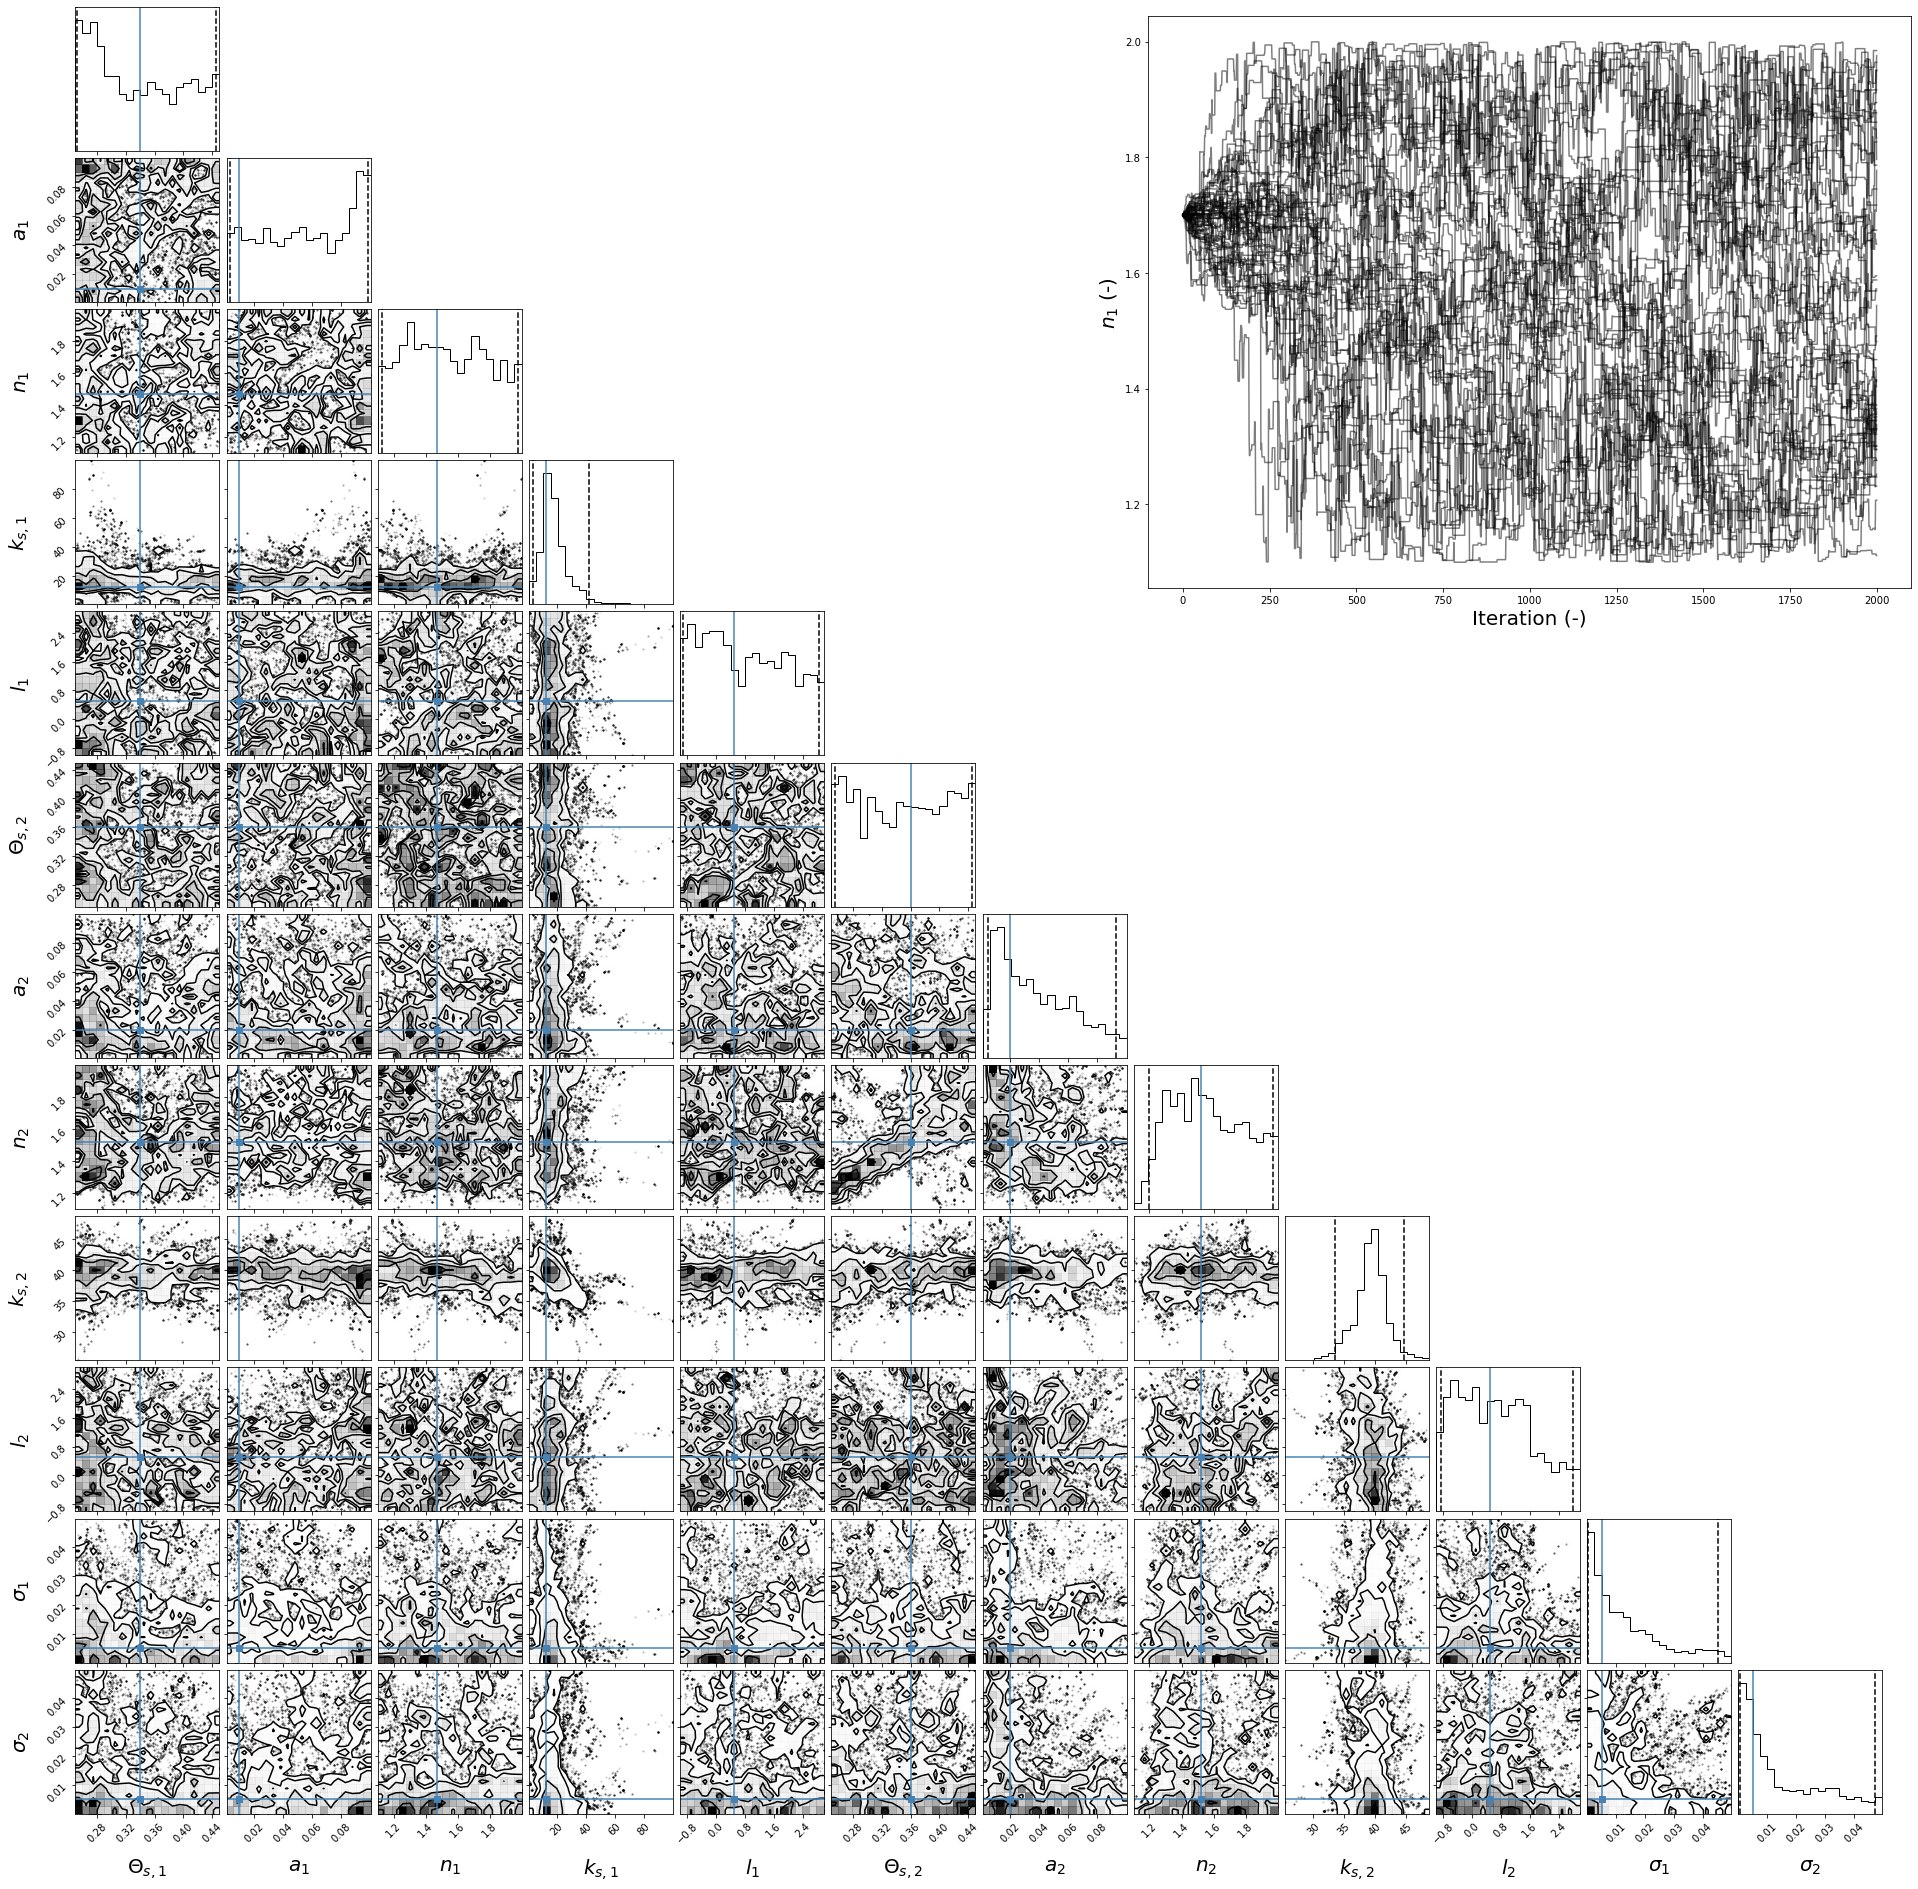

In [10]:
labels = ["$\Theta_{s,1}$", "$a_1$", "$n_1$", "$k_{s,1}$", "$l_1$", 
          "$\Theta_{s,2}$", "$a_2$", "$n_2$", "$k_{s,2}$", "$l_2$",
          "$\sigma_1$", "$\sigma_2$"]

# Make corner plot
fig = plt.figure(figsize=(10,10))
axes = corner.corner(chains, quantiles=[0.025, 0.975], truths=truth,
                     labels=labels, label_kwargs=dict(fontsize=20));

# Show walkers for parameter X
ax2 = plt.axes([0.6, 0.68, 0.4, 0.3])
plt.plot(walkers[:, :, 2], color="k", alpha=0.5);
plt.ylabel('$n_{1}$ (-)', fontsize=20)
plt.xlabel('Iteration (-)', fontsize=20);
plt.savefig("../figures/mcmc_results.pdf", bbox_inches="tight", dpi=300)

## Mean Acceptance Rate

In [11]:
acc_frac = np.mean(reader.accepted / reader.iteration)
print("The mean acceptance rate is:", acc_frac)

The mean acceptance rate is: 0.14337000000000003


In [12]:
modeled = ml.read_obs_node()
mod_1 = modeled[ml.obs_nodes[0]].loc[:,'theta']
mod_2 = modeled[ml.obs_nodes[1]].loc[:,'theta']

<AxesSubplot:xlabel='time'>

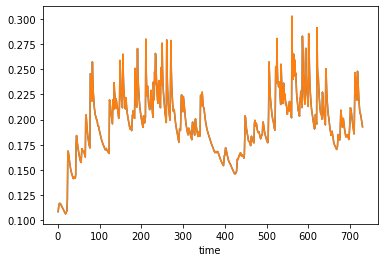

In [13]:
mod_1.plot()
vwc_1.plot()

<AxesSubplot:xlabel='time', ylabel='$\\Theta_{w,2}$ [-]'>

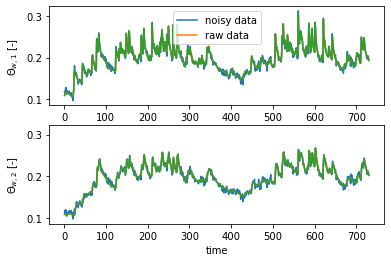

In [14]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(6, 4), sharey=True)

synth_vwc_1.plot(ax=ax1, label="noisy data")
vwc_1.plot(ax=ax1, label="raw data")
ax1.legend(ncol=2, bbox_to_anchor=[0,1], loc=3)
ax1.set_ylabel("$\Theta_{w,1}$ [-]")
mod_1.plot(ax=ax1)

synth_vwc_2.plot(ax=ax2)
vwc_2.plot(ax=ax2)
ax2.set_ylabel("$\Theta_{w,2}$ [-]");
mod_2.plot(ax=ax2)

In [15]:
print(lnlike(truth, synth_vwc_1, synth_vwc_2))

-1341.6573541322102
